# Saving PYTHIA events as ROOT trees
    This tutorial shows how to save PYTHIA events as ROOT trees. We will modify pythia parton distribution functions and fragmentation functions, and save the resulting events as ROOT trees.
    ROOT is a data analysis framework developed at CERN. It is written in C++, but has Python bindings. It is used by the CMS and ATLAS experiments at the LHC, and by many other experiments around the world. 
(See [here](https://root.cern.ch/) for more information.)

### Imports
This is how we tell python what packages we want to use. We will be using the following packages:
* [Pythia](http://home.thep.lu.se/~torbjorn/Pythia.html) - The event generator we will be using
* [ROOT](https://root.cern.ch/) - The data analysis framework we will be using
* [os](https://docs.python.org/2/library/os.html) - A package for interacting with the operating system
* [time](https://docs.python.org/2/library/time.html) - A package for measuring time
* [numpy](http://www.numpy.org/) - A package for doing math with arrays
```python

In [1]:
import numpy as np # Import numpy
import ROOT # Import ROOT
import pythia8 # Import pythia8
import os # Import os 
import time # Import time

Welcome to JupyROOT 6.26/02


## Example : Using pythiaObj

The pythiaObj class controls the settings of pythia and initializes them for us when we are ready. 
The default settings are: 
- 5.02 TeV proton-proton collisions, hard QCD processes on
The pythiaObj class has a number of methods that allow us to change the settings of pythia.
- HardQCD(on/off) : Turns hard QCD processes on or off
- PDF(number, extrapolation=True) : Sets the PDF to use and turns on extrapolation if desired (default is on)
- Fragmentation('string',value) : Sets the fragmentation parameters for aLund and bLund strings (default is '0.68 0.98')
- Tune(number) : Sets the tune to use
- DefaultSettings() : Resets the settings to the default settings (5.02 TeV proton-proton collisions, hard QCD processes on)
- ResetSettings(beam energy, beam a, beam b, nevents) : Resets the settings to the given values

The pythiaObj class also has a number of methods that allow us to get information about the settings of pythia.
- GetSettings() : Returns a dictionary of the settings
- WriteSettings(filename) : Writes the settings to a file

Aswell as methods to initialize pythia and generate events.
- Init() : Initializes pythia with the current settings
- Next() : Generates and returns the next event

```python

In [7]:
class pythiaObj:
    ''' A class to hold the pythia object and its settings '''
    
    def __init__(self, beamEnergy, beamA, beamB, nevents = 1000):
        ''' Initialize the pythia object'''
        self.settings = []
        inputparams = ['Beams:eCM', 'Beams:idA', 'Beams:idB', 'Main:numberOfEvents']
        inputs = [beamEnergy, beamA, beamB, nevents]
        for i in range(len(inputparams)):
            self.settings.append(f'{inputparams[i]} = {inputs[i]}')
        self.settings.append("HardQCD:all = on")
        self.Seed() # Set the seed
        
    def Seed(self):
        ''' 
        Set the seed for the pythia object based on the time.
        '''
        # random seed based on time
        seed = (time.time()*100000)%900000 
        seed = int(seed)
        print("Seed: {}".format(seed))
        # seed needs to be between 0 and 900000000
        if seed < 0:
            seed *= -1
        seedstrs = ["Random:setSeed = on", "Random:seed = {}".format(seed)]
        # remove all seed options
        self.settings = [x for x in self.settings if not 'Random' in x]
        for seedstr in seedstrs:
            self.settings.append(seedstr)
       
    def GetSettings(self):
        ''' Get the current settings of the pythia object '''
        return self.settings
        
    def WriteSettings(self, filename):
        ''' Write the current settings to a file '''
        with open(filename, 'w') as f:
            for key in self.settings:
                f.write(key + '\n')
        
    def DefaultSettings(self):
        ''' Reset the settings to default '''
        setstrs = []
        setstrs.append("Beams:eCM = 5020")
        setstrs.append("Beams:idA = 2212")
        setstrs.append("Beams:idB = 2212")
        setstrs.append("Main:numberOfEvents = 10000")
        setstrs.append("HardQCD:all = on")
        self.settings = setstrs
        self.Seed()
    
    def ResetSettings(self, beamEnergy, beamA, beamB, nevents = 1000):
        ''' Reset the settings '''
        self.settings = []
        inputparams = ['Beams:eCM', 'Beams:idA', 'Beams:idB', 'Main:numberOfEvents']
        inputs = [beamEnergy, beamA, beamB, nevents]
        for i in range(len(inputparams)):
            self.settings.append(f'{inputparams[i]} = {inputs[i]}')
        self.settings.append("HardQCD:all = on")
        self.Seed()
        
    def pTHard(self, min, max =-1):
        ''' Set the pTHard min and max '''
        # remove all pTHard options
        self.settings = [x for x in self.settings if not 'pTHard' in x]
        if max == -1:
            self.settings.append("PhaseSpace:pTHatMin = {}".format(min))
        else:
            self.settings.append("PhaseSpace:pTHatMin = {}".format(min))
            self.settings.append("PhaseSpace:pTHatMax = {}".format(max))
                
    def HardQCD(self, option=True):
        ''' Set the HardQCD option'''
        # remove all HardQCD options
        self.settings = [x for x in self.settings if not 'HardQCD' in x]
        if option:
            self.settings.append("HardQCD:all = on")
        else:
            self.settings.append("HardQCD:all = off")
      
    def PDF(self, pdf, extrapolate = True):
        ''' Set the PDF '''
        # remove all PDF options
        self.settings = [x for x in self.settings if not 'PDF' in x]
        self.settings.append("PDF:pSet = {}".format(pdf))
        if extrapolate:
            self.settings.append("PDF:extrapolate = on")
        else:
            self.settings.append("PDF:extrapolate = off")
    
    def ResetPDF(self):
        ''' Reset the PDF to default '''
        self.settings = [x for x in self.settings if not 'PDF' in x]
        self.settings.append("PDF:pSet = 13")
        self.settings.append("PDF:extrapolate = off")
             
    def Fragmentation(self, Lstring, value):
        ''' Set the fragmentation '''
        if Lstring != 'aLund' and Lstring != 'bLund':
            print("Error: Lstring must be 'aLund' or 'bLund'")
            return
        # remove all fragmentation options
        self.settings = [x for x in self.settings if not Lstring in x]
        self.settings.append("StringZ:{} = {}".format(Lstring, value))
        
    def ResetFragmentation(self):
        ''' Reset the fragmentation to default '''
        self.settings = [x for x in self.settings if not 'StringZ' in x]
        self.settings.append("StringZ:aLund = 0.68")
        self.settings.append("StringZ:bLund = 0.98")
        
    def Tune(self, tune):
        ''' Set the tune '''
        # remove all tune options
        self.settings = [x for x in self.settings if not 'Tune' in x]
        self.settings.append("Tune:pp = {}".format(tune))
    
    def Init(self):
        ''' Initialize the pythia object '''
        self.pythia = pythia8.Pythia()
        for key in self.settings:
            self.pythia.readString(key)
        # Initialize the pythia object with minimal output
        self.pythia.readString("Next:numberShowEvent = 0")
        self.pythia.readString("Next:numberShowProcess = 0")
        self.pythia.readString("Next:numberShowInfo = 0")
        self.pythia.readString("Next:numberShowLHA = 0")
        self.pythia.readString("Init:showChangedSettings = off")
        self.pythia.readString("Init:showAllSettings = off")
        self.pythia.readString("Init:showProcesses = off")
        self.pythia.init()
              
    def Next(self):
        ''' Generate the next event '''
        if not self.pythia.next():
            print("Error: event generation failed!")
            return
        event = self.pythia.event
        return event

We want to modify the underlying physics of pythia. We will do this by changing the parton distribution functions and the fragmentation functions. 
A parton distribution function (PDF) is a function that describes the probability of finding a parton with a given momentum fraction x of the proton's momentum. There are many different PDFs, and they are usually determined by fitting to experimental data. The default PDF in pythia in 13. (See [here](http://home.thep.lu.se/~torbjorn/pythia81html/ParticleDataScheme.html) for more information.)

Avaible PDFS 
-  1 : GRV 94L, LO alpha_s(M_Z) = 0.128 (this set is out of date, but retained for historical comparisons).
-  2 : CTEQ 5L, LO alpha_s(M_Z) = 0.127 (this set is also out of date, but not badly so, and many tunes are based on it).
-  3 : MRST LO* (2007), NLO alpha_s(M_Z) = 0.12032.
-  4 : MRST LO** (2008), NLO alpha_s(M_Z) = 0.11517.
-  5 : MSTW 2008 LO (central member), LO alpha_s(M_Z) = 0.13939.
-  6 : MSTW 2008 NLO (central member), NLO alpha_s(M_Z) = 0.12018 (NLO, see Warning 3 above).
-  7 : CTEQ6L, NLO alpha_s(M_Z) = 0.1180.
-  8 : CTEQ6L1, LO alpha_s(M_Z) = 0.1298.
-  9 : CTEQ66.00 (NLO, central member), NLO alpha_s(M_Z) = 0.1180 (NLO, see Warning 3 above).
-  10 : CT09MC1, LO alpha_s(M_Z) = 0.1300.
-  11 : CT09MC2, NLO alpha_s(M_Z) = 0.1180.
-  12 : CT09MCS, NLO alpha_s(M_Z) = 0.1180.
-  13 : NNPDF2.3 QCD+QED LO alpha_s(M_Z) = 0.130.
-  14 : NNPDF2.3 QCD+QED LO alpha_s(M_Z) = 0.119.
-  15 : NNPDF2.3 QCD+QED NLO alpha_s(M_Z) = 0.119.
-  16 : NNPDF2.3 QCD+QED NNLO alpha_s(M_Z) = 0.119.
Warning :the following four NNPDF 3.1 sets are quite different from the NNPDF 2.3 ones, and cannot be used interchangeably, but need retuning of the MPI framework. Some also do not contain QED evolution.
-  17 : NNPDF3.1 QCD LO alpha_s(M_Z) = 0.130.
-  18 : NNPDF3.1 QCD LO alpha_s(M_Z) = 0.118.
-  19 : NNPDF3.1 QCD+LUXQED NLO alpha_s(M_Z) = 0.118.
-  20 : NNPDF3.1 QCD+LUXQED NNLO alpha_s(M_Z) = 0.118.
-  21 : NNPDF3.1sx+LHCb NLO+NLLx LUXQED alpha_s(M_Z) = 0.118 [Ber18]. While at NLO, the additional small-x resummation, anchored by LHC-b data, offers a more reasonable small-x behaviour than most NLO PDFs, as required for the successful usage e.g. with traditional "improved LL" parton showers. The photon part is unchanged from the earlier NNPDF 3.1 QED analysis [Ber17].
Warning :in version 8.235 the 21 identifier was used to denote and earlier attempt to obtain a more reasonable small-x behaviour. This PDF set is superseded by the new 21 and 22 sets, and has been removed, as was forewarned.
-  22 : NNPDF3.1sx+LHCb NNLO+NLLx LUXQED alpha_s(M_Z) = 0.118. Comments as for 21, but this set is at NNLO rather than NLO.
-  23 : GJR LO (2007).
-  24 : SU (2021). This is a simple parameterization based on the same approach as other SU21 sets. It is intended for comparison with those sets, but is too inaccurate to use for practical applications.

The PDF's we will use are 4 (MRST LO** (2008), NLO alpha_s(M_Z) = 0.11517), 8 (CTEQ6L1, LO alpha_s(M_Z) = 0.1298), and 15 (NNPDF2.3 QCD+QED NLO alpha_s(M_Z) = 0.119). 
```python

## Changing the PDF
We will now change the PDF to 4 (MRST LO** (2008), NLO alpha_s(M_Z) = 0.11517) using the PDF method of the pythiaObj class. 
```python

In [8]:
pyt = pythiaObj(beamEnergy = 5020, beamA = 2212, beamB = 2212, nevents = 10000) # Initialize the pythia object for 5.02 TeV p+p collisions
pyt.pTHard(20) # Set the pTHard min to 20 GeV
pyt.PDF(4) # Set the PDF

print("Settings")
settings = pyt.GetSettings()
for key in settings:
    print(key)

pyt.Init() # Initialize the pythia object
event = pyt.Next() # Generate the next event

Seed: 314600
Settings
Beams:eCM = 5020
Beams:idA = 2212
Beams:idB = 2212
Main:numberOfEvents = 10000
HardQCD:all = on
Random:setSeed = on
Random:seed = 314600
PhaseSpace:pTHatMin = 20
PDF:pSet = 4
PDF:extrapolate = on

 *------------------------------------------------------------------------------------* 
 |                                                                                    | 
 |  *------------------------------------------------------------------------------*  | 
 |  |                                                                              |  | 
 |  |                                                                              |  | 
 |  |   PPP   Y   Y  TTTTT  H   H  III    A      Welcome to the Lund Monte Carlo!  |  | 
 |  |   P  P   Y Y     T    H   H   I    A A     This is PYTHIA version 8.305      |  | 
 |  |   PPP     Y      T    HHHHH   I   AAAAA    Last date of change:  3 May 2021  |  | 
 |  |   P       Y      T    H   H   I   A   A                        

The settings look correct. 
The Seed is a random number that is used to initialize the random number generator. We use a different seed for each run so that we get different events each time. 
```python

## Modifying the Fragmentation Functions
Fragmentation functions describe the probability of a parton fragmenting into a hadron. There are many different fragmentation functions, and they are usually determined by fitting to experimental data. The default fragmentation function in pythia is the Lund symmetric fragmentation function. (See [here](http://home.thep.lu.se/~torbjorn/pythia81html/ParticleDataScheme.html) for more information.)

The Lund symmetric fragmentation function is the only alternative for light quarks. It is of the form

$f(z) = (1/z) * (1-z)^a * exp(-b m_T^2 / z)$


with the two main free parameters a and b to be tuned to data. They are stored in

- StringZ:aLund   (default = 0.68; minimum = 0.0; maximum = 2.0) The a parameter of the Lund symmetric fragmentation function.

- StringZ:bLund   (default = 0.98; minimum = 0.2; maximum = 2.0) The b parameter of the Lund symmetric fragmentation function.

In [9]:
pyt = pythiaObj(beamEnergy = 5020, beamA = 2212, beamB = 2212, nevents = 10000) # Initialize the pythia object for 5.02 TeV p+p collisions
pyt.pTHard(20) # Set the pTHard min to 20 GeV
pyt.Fragmentation('aLund', 0.2) # Set the aLund parameter
pyt.Fragmentation('bLund', 0.5) # Set the bLund parameter

print("Settings")
settings = pyt.GetSettings()
for key in settings:
    print(key)

pyt.Init() # Initialize the pythia object
event = pyt.Next() # Generate the next event

Seed: 480580
Settings
Beams:eCM = 5020
Beams:idA = 2212
Beams:idB = 2212
Main:numberOfEvents = 10000
HardQCD:all = on
Random:setSeed = on
Random:seed = 480580
PhaseSpace:pTHatMin = 20
StringZ:aLund = 0.2
StringZ:bLund = 0.5

 *------------------------------------------------------------------------------------* 
 |                                                                                    | 
 |  *------------------------------------------------------------------------------*  | 
 |  |                                                                              |  | 
 |  |                                                                              |  | 
 |  |   PPP   Y   Y  TTTTT  H   H  III    A      Welcome to the Lund Monte Carlo!  |  | 
 |  |   P  P   Y Y     T    H   H   I    A A     This is PYTHIA version 8.305      |  | 
 |  |   PPP     Y      T    HHHHH   I   AAAAA    Last date of change:  3 May 2021  |  | 
 |  |   P       Y      T    H   H   I   A   A                  

# Writing output to file
The results of our simulation need to be stored in a file so that we can analyze them later. We will use a root TTree to store the results. 
```python

A TFile is a file that is native to ROOT. It can contain TTrees, histograms, and other ROOT objects. We will create a new sub-directory to store out TFile and the settings of the pythiaObj. Saving the settings of the pythiaObj will allow us to reproduce the results of the simulation later. 
TFile info: (if you want to see the contents of the TFile, you can open it in ROOT by typing "root -l filename.root" in the terminal)
 

Within the TFile we will store the TTree. A TTree is a ROOT object that can store data in a table. Each column of the table is a branch of the TTree. We will create a TTree with the following branches:
- event multiplicity (number of particles in the event)
- particle id (the id of the particle)
- particle px (the x component of the momentum of the particle)
- particle py (the y component of the momentum of the particle)
- particle pz (the z component of the momentum of the particle)
- particle energy (the energy of the particle)

We will save the particle information in arrays with length equal to the event multiplicity. 
```python

# Make new directory for output

In [20]:
# check current directory
current_list = os.listdir()

# use os.system to mkdir
# make new directory
os.system('mkdir -p testdir') # Make a new directory called testdir

# check for new objects in current directory
new_list = os.listdir()
for item in new_list:
    if item not in current_list:
        print("New item: {}".format(item))

New item: testdir


# Initialize TFile and TTree

In [27]:
filename = 'testdir/testfile.root' # Set the filename to testdir/testfile.root

f = ROOT.TFile(filename, 'recreate') # Create a new ROOT file
tree = ROOT.TTree('tree', 'tree') # Create a new tree

# define branch variables
event_multiplicity = np.zeros(1, dtype=int) # Create a new branch for the event multiplicity
particle_px = np.zeros(10000, dtype=float) # Create a new branch for the particle px
particle_py = np.zeros(10000, dtype=float) # Create a new branch for the particle py
particle_pz = np.zeros(10000, dtype=float) # Create a new branch for the particle pz
particle_E = np.zeros(10000, dtype=float) # Create a new branch for the particle E
particle_pid = np.zeros(10000, dtype=int) # Create a new branch for the particle pid

# add branches to tree
tree.Branch('event_multiplicity', event_multiplicity, 'event_multiplicity/I') # Add the event multiplicity branch to the tree
tree.Branch('particle_px', particle_px, 'particle_px[event_multiplicity]/D') # Add the particle px branch to the tree
tree.Branch('particle_py', particle_py, 'particle_py[event_multiplicity]/D') # Add the particle py branch to the tree
tree.Branch('particle_pz', particle_pz, 'particle_pz[event_multiplicity]/D') # Add the particle pz branch to the tree
tree.Branch('particle_E', particle_E, 'particle_E[event_multiplicity]/D') # Add the particle E branch to the tree
tree.Branch('particle_pid', particle_pid, 'particle_pid[event_multiplicity]/I') # Add the particle pid branch to the tree

# Initialize Pythia and save some events

In [28]:
settings_filename = 'testdir/settings.txt' # Set the filename to testdir/testfile.txt
pyt = pythiaObj(beamEnergy = 5020, beamA = 2212, beamB = 2212) # Initialize the pythia object for 5.02 TeV p+p collisions
pyt.pTHard(20) # Set the pTHard min to 20 GeV
pyt.PDF(4) # Set the PDF
pyt.WriteSettings(settings_filename) # Write the settings to a file
pyt.Init() # Initialize the pythia object


nevents = 500 # Number of events to generate
for i in range(nevents): # Loop over the events
    event = pyt.Next() # Generate the next event
    event_multiplicity[0] = 0
    
    for j in range(event.size()):
        if not event[j].isFinal(): # Skip if the particle is not final
            continue
        event_multiplicity[0] += 1 # Increment the event multiplicity
        
        particle = event[j] # Get the particle
        particle_px[j] = particle.px() # Set the particle px
        particle_py[j] = particle.py() # Set the particle py
        particle_pz[j] = particle.pz() # Set the particle pz
        particle_E[j] = particle.e() # Set the particle E
        particle_pid[j] = particle.id() # Set the particle pid
        
    # Fill the tree
    tree.Fill() # Fill the tree
    
    # Print the event number every 100 events
    if i%100 == 0:
        print("Event: {}".format(i))

# Write the tree to the ROOT file
f.Write() # Write the ROOT file
f.Close() # Close the ROOT file

Seed: 744597
Event: 0
Event: 100
Event: 200
Event: 300
Event: 400

 *------------------------------------------------------------------------------------* 
 |                                                                                    | 
 |  *------------------------------------------------------------------------------*  | 
 |  |                                                                              |  | 
 |  |                                                                              |  | 
 |  |   PPP   Y   Y  TTTTT  H   H  III    A      Welcome to the Lund Monte Carlo!  |  | 
 |  |   P  P   Y Y     T    H   H   I    A A     This is PYTHIA version 8.305      |  | 
 |  |   PPP     Y      T    HHHHH   I   AAAAA    Last date of change:  3 May 2021  |  | 
 |  |   P       Y      T    H   H   I   A   A                                      |  | 
 |  |   P       Y      T    H   H  III  A   A    Now is 13 Sep 2023 at 14:11:13    |  | 
 |  |                                      

# Read and check the settings of the pythiaObj
```python

In [23]:
current_settings = pyt.GetSettings() # Get the current settings (before reset)

# read settings from file
settings_from_file = []
with open(settings_filename, 'r') as f:
    for line in f:
        settings_from_file.append(line.strip())
        
# check if settings are the same
file_settings_length = len(settings_from_file)
checker_iterator = 0
print("pythiaObj settings\tFile settings")
for i in range(len(current_settings)):
    if i >= file_settings_length:
       break
    if current_settings[i] == settings_from_file[i]:
       print("{}\t{}".format(current_settings[i], settings_from_file[i]))
       checker_iterator += 1
    else:
        print("***** {} != {} *****".format(current_settings[i], settings_from_file[i]))
    checker_iterator += 1
for i in range(checker_iterator, file_settings_length):
    print("***** {} != {} *****".format(current_settings[i], settings_from_file[i]))      


pythiaObj settings	File settings
Beams:eCM = 5020	Beams:eCM = 5020
Beams:idA = 2212	Beams:idA = 2212
Beams:idB = 2212	Beams:idB = 2212
Main:numberOfEvents = 1000	Main:numberOfEvents = 1000
HardQCD:all = on	HardQCD:all = on
Random:setSeed = on	Random:setSeed = on
Random:seed = 811366	Random:seed = 811366
PhaseSpace:pTHatMin = 20	PhaseSpace:pTHatMin = 20
PDF:pSet = 4	PDF:pSet = 4
PDF:extrapolate = on	PDF:extrapolate = on


# Check contents of TFile
```python

******************************************************************************
*Tree    :tree      : tree                                                   *
*Entries :      500 : Total =         7651556 bytes  File  Size =    1435100 *
*        :          : Tree compression factor =   5.34                       *
******************************************************************************
*Br    0 :event_multiplicity : event_multiplicity/I                          *
*Entries :      500 : Total  Size=       2622 bytes  File Size  =       1127 *
*Baskets :        1 : Basket Size=      32000 bytes  Compression=   1.85     *
*............................................................................*
*Br    1 :particle_px : particle_px[event_multiplicity]/D                    *
*Entries :      500 : Total  Size=    1699528 bytes  File Size  =     341394 *
*Baskets :       56 : Basket Size=      32000 bytes  Compression=   4.97     *
*...................................................

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c


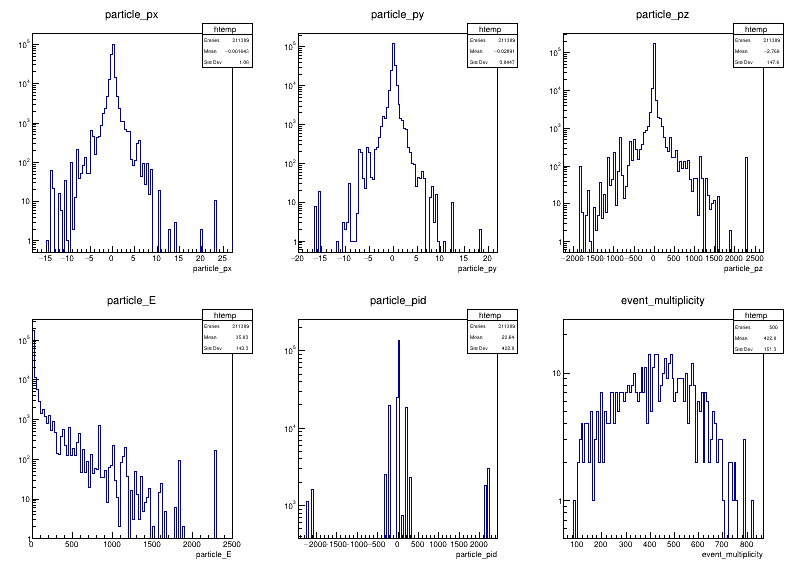

In [32]:
# open the file
f = ROOT.TFile(filename, 'read') # Open the ROOT file
tree = f.Get('tree') # Get the tree from the ROOT file
tree.Print() # Print the tree

# create histograms
c = ROOT.TCanvas('c', 'c', 800, 600) # Create a new canvas
c.Divide(3,2) # Divide the canvas into 2x2 pads
c.cd(1) # Switch to the first pad
c.cd(1).SetLogy() # Set the y-axis to log scale
tree.Draw('particle_px')
c.cd(2) # Switch to the second pad
c.cd(2).SetLogy() # Set the y-axis to log scale
tree.Draw('particle_py') # Draw the particle py
c.cd(3) # Switch to the third pad
c.cd(3).SetLogy() # Set the y-axis to log scale
tree.Draw('particle_pz') # Draw the particle pz
c.cd(4) # Switch to the fourth pad
c.cd(4).SetLogy() # Set the y-axis to log scale
tree.Draw('particle_E') # Draw the particle E
c.cd(5) # Switch to the fifth pad
c.cd(5).SetLogy() # Set the y-axis to log scale
tree.Draw('particle_pid') # Draw the particle pid
c.cd(6) # Switch to the sixth pad
c.cd(6).SetLogy() # Set the y-axis to log scale
tree.Draw('event_multiplicity') # Draw the event multiplicity
c.Draw() # Draw the canvas
